# Torch-dreams

This library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

<img src = "https://github.com/Mayukhdeb/torch-dreams/raw/master/images/banner_1.png?raw=true">

torch-dreams aims to be something like [tensorflow/lucid](https://github.com/tensorflow/lucid) but in PyTorch in order to facilitate research in neural network interpretability

## Quick start 

In [1]:
# !pip install torch-dreams  --upgrade
!pip install git+https://github.com/Mayukhdeb/torch-dreams  ## for testing only 

  Cloning https://github.com/Mayukhdeb/torch-dreams to /tmp/pip-req-build-dfbl8r7s
  Running command git clone -q https://github.com/Mayukhdeb/torch-dreams /tmp/pip-req-build-dfbl8r7s
  Created wheel for torch-dreams: filename=torch_dreams-1.2.0-cp37-none-any.whl size=15325 sha256=75bba34f75435a19fd60f55a6d6407ed71dfd13245e18fa9e322225d5733d42d
  Stored in directory: /tmp/pip-ephem-wheel-cache-equdf8qj/wheels/fa/c7/e6/faa8064e9c3cff31178c8ffa0a8090e07be9a7ce2c82e829c1
Successfully built torch-dreams


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams.dreamer import dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

## Minimal example

In [3]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model,  device = 'cuda', quiet =  False)

In [ ]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
)

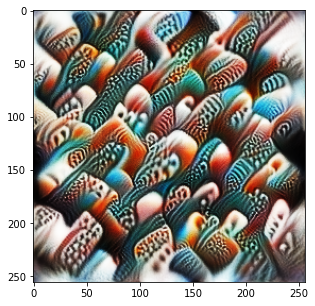

In [52]:
plt.imshow(image_param.rgb.astype(np.float32))
plt.show()

## Not so minimal looking example, but does the same thing as above



In [ ]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
    width = 512,
    height = 256,
    iters = 150,
    lr = 9e-3,
    rotate_degrees = 15,
    scale_max = 1.2,
    scale_min =  0.5,
    custom_func = None,
    weight_decay = 1e-2,
    grad_clip = 1,
)

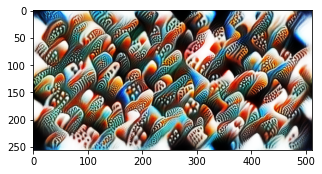

In [50]:
plt.imshow(image_param.rgb.astype(np.float32))
plt.show()

## Visualizing individual channels


We basically optimize the input image to maximize activations of a certain channel of a layer in the neural network.

In [79]:
"""
feel free to use more layers for experiments 
"""
layers_to_use = [model.Mixed_6b.branch1x1.conv]


The next step now would be to define a `custom_func` that would enable use to selectively optimize a single channel. We could've made a simpler function, but this would be useful when we'll be running the optimizations on a lot of channels

In [80]:
def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func

Now in order to optimize the **7th channel** of the **first layer** mentioned in `layers_to_use` we define the custom loss as:



In [84]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 119)

In [ ]:
image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func = my_custom_func,
)

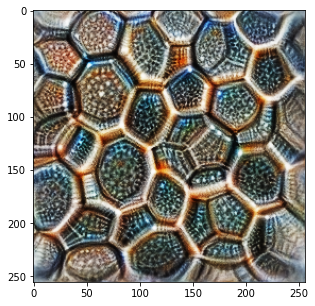

In [86]:
plt.imshow(image_param.rgb.astype(np.float32))
plt.show()

## Blending

In [ ]:
def write_image(im, filename):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    cv2.imwrite(filename, (im*255).astype(np.uint8))

In [ ]:
layers_to_use = [
                 model.Mixed_6c.branch7x7_1.conv,
                 model.Mixed_6b.branch7x7dbl_2
            ]

In [ ]:
def custom_func_1(layer_outputs):
    loss = layer_outputs[0][7].mean() 
    return loss

def custom_func_2(layer_outputs):
    loss = layer_outputs[1][88].mean()
    return loss

In [ ]:
config = {
    "image_path": "seed.jpg",
    "layers": layers_to_use,
    "octave_scale": 1.1,  
    "num_octaves": 14,  
    "iterations": 70,  
    "lr": 0.05,
    "max_rotation": 0.9,
    "gradient_smoothing_kernel_size": None,
    "gradient_smoothing_coeff": None
}

100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


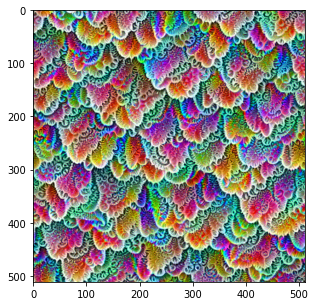

In [ ]:
config["custom_func"] = custom_func_1
out_1 = dreamy_boi.deep_dream(config)
plt.imshow(out_1)
plt.show()
write_image(out_1, "inception_v3.Mixed_6c.branch7x7_1.conv_channel_7.jpg")

100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


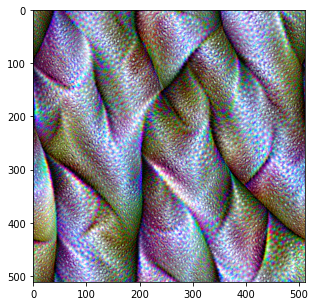

In [ ]:
config["custom_func"] = custom_func_2
out_2 = dreamy_boi.deep_dream(config)
plt.imshow(out_2)
plt.show()
write_image(out_2, "inception_v3.Mixed_6b.branch7x7dbl_2_channel_88.jpg")


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


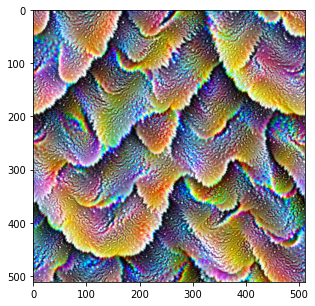

In [ ]:
def custom_func_combined(layer_outputs):
    loss = layer_outputs[0][7].mean()*2.0 + layer_outputs[1][88].mean()
    return loss
    
config["custom_func"] = custom_func_combined
out_blend = dreamy_boi.deep_dream(config)
plt.imshow(out_blend)
plt.show()

write_image(out_blend, "add_inception_v3.Mixed_6b.branch7x7dbl_2_channel_88_inception_v3.Mixed_6c.branch7x7_1.conv_channel_7.jpg")

100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


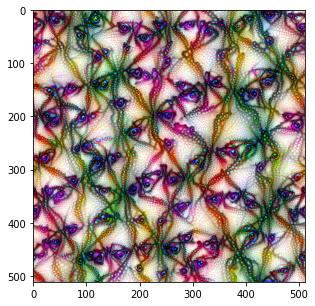

In [ ]:
def custom_func_3(layer_outputs):
    loss = layer_outputs[0][31].mean()
    return loss
    
config["custom_func"] = custom_func_3
out_3 = dreamy_boi.deep_dream(config)
plt.imshow(out_3)
plt.show()
write_image(out_3, "inception_v3.Mixed_6c.branch7x7_1.conv_channel_31.jpg")

100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


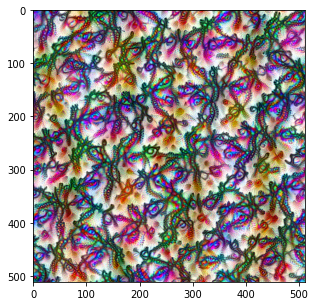

In [ ]:
def custom_func_diff(layer_outputs):
    loss =  layer_outputs[0][7].mean() - layer_outputs[1][88].mean() + layer_outputs[0][31].mean()
    return loss

config["custom_func"] = custom_func_diff
out_diff = dreamy_boi.deep_dream(config)
plt.imshow(out_diff)
plt.show()
write_image(out_diff, "inception_v3.Mixed_6c.branch7x7_1.conv_channel_7_minus_inception_v3.Mixed_6b.branch7x7dbl_2_channel_88_plus_inception_v3.Mixed_6c.branch7x7_1.conv_channel_31.jpg")